# 텐서플로우 튜토리얼 #01
# 단순 선형 모델

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## 소개

이 튜토리얼은 단순한 선형 모델과 함께 텐서플로우를 사용하는 기본적인 워크플로우를 보여준다. 자필 숫자 영상이 있는 이른바 MNIST 데이터 세트를 로드한 후 텐서플로에서 간단한 수학 모델을 정의하고 최적화한다. 그런 다음 결과를 계획하고 논의한다.


기본 선형대수, 파이톤과 주피터 공책 편집자에 익숙해져야 한다. 기계학습과 분류에 대한 기본적인 이해가 있으면 도움이 된다고 말했다.

## 텐서플로우 2

이 튜토리얼은 2016년에 텐서플로 v.1을 사용하여 개발되었다. TensorFlow v.2에서는 상당한 API 변경이 있었다. 본 자습서는 \"v.1 compatibility mode\"에서 TF2를 사용하며, TensorFlow의 작동 방식을 배우는 데 여전히 유용하지만 TF2에서는 약간 다르게 구현해야 한다(Keras API의 자습서 03C 참조). 구글의 엔지니어들이 텐서플로 API를 업데이트할 때마다 이런 튜토리얼을 계속 업데이트하는 것은 나에게 너무 큰 일이기 때문에, 결국 이 튜토리얼이 작동을 멈출 수도 있다.

## Imports

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [27]:
# 이 오래된 v.1 코드와 함께 텐서플로 v.2를 사용하십시오.
# 이 오래된 v.1 코드와 함께 텐서플로 v.2를 사용하십시오.
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

ModuleNotFoundError: No module named 'tensorflow'

이것은 Python 3.6 (Anaconda)과 TensorFlow 버전을 사용하여 개발되었다.

In [28]:
tf.__version__

NameError: name 'tf' is not defined

## 데이터 로드

MNIST 데이터 세트는 약 12MB로 주어진 경로에 위치하지 않으면 자동으로 다운로드된다.

In [29]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

MNIST 데이터 세트는 현재 로드되었으며 이미지용 70.000개의 영상과 클래스 번호로 구성되어 있다. 데이터 세트는 3개의 상호 배타적인 하위 세트로 분할된다. 이번 튜토리얼에서는 훈련과 시험 세트만 사용할 것이라고 말했다.

In [30]:
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


편리를 위해 데이터 치수 일부를 복사하십시오.

In [31]:
# 영상은 이 길이의 1차원 배열로 저장된다.
img_size_flat = data.img_size_flat

# 배열을 재구성하는 데 사용되는 이미지의 높이와 폭을 가진 튜플.
img_shape = data.img_shape

# 클래스 수, 열 자리마다 한 클래스씩.
num_classes = data.num_classes

### One-Hot 인코딩

출력 데이터는 정수 클래스 번호와 소위 One-Hot 인코딩된 배열로 모두 로드된다. 이것은 클래스 번호들이 하나의 정수에서 가능한 클래스의 수와 길이가 같은 벡터로 변환되었음을 의미한다. 벡터의 모든 요소는 $i$'원소 1을 제외하고 0이며, 클래스가 $i$임을 의미한다. 예를 들어, 테스트 세트의 처음 5개 이미지에 대한 One-Hot 인코딩된 라벨이 있다.

In [32]:
data.y_test[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

우리는 또한 다양한 비교와 성과 측정을 위한 정수로서 클래스가 필요하다. 이는 원핫 인코딩 어레이에서 np.argmax() 함수를 사용하여 가장 높은 요소의 인덱스를 추출하여 확인할 수 있다. 하지만 이것은 데이터 세트가 로드되었을 때 이미 우리에게 행해졌기 때문에 우리는 테스트 세트의 처음 5개 영상의 클래스 번호를 볼 수 있다. 위의 One-Hot 인코딩 어레이와 비교해 보십시오.

In [33]:
data.y_test_cls[0:5]

array([7, 2, 1, 0, 4])

### 이미지 플롯을 위한 도우미 함수

함수는 9개의 영상을 3x3 그리드에 플로팅하고 각 이미지 아래에 참 클래스와 예측 클래스를 작성하는 데 사용된다.

In [34]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # 3x3 서브플롯으로 피규어를 만든다.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # 플롯 이미지.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # 진실되고 예측되는 클래스를 보여라.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # 줄거리에서 눈금을 제거하라.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # 여러 플롯을 사용하여 플롯이 올바르게 표시되도록 하십시오.
    # 노트북 한 셀 안에.
    plt.show()

### 데이터가 올바른지 보기 위해 몇 개의 이미지를 플롯하십시오.

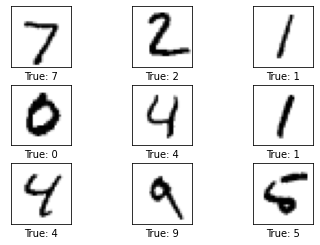

In [35]:
# 테스트 세트에서 첫 번째 영상을 얻으십시오.
images = data.x_test[0:9]

# 그 이미지들에 대한 진정한 클래스를 받으세요.
cls_true = data.y_test_cls[0:9]

# 위의 도우미 함수를 사용하여 이미지와 라벨을 플롯하십시오.
plot_images(images=images, cls_true=cls_true)

## 텐서플로우 그래프

텐서플로우의 전체 목적은 파이톤에서 직접 동일한 계산을 수행할 경우보다 훨씬 효율적으로 실행할 수 있는 이른바 계산 그래프를 갖추는 것이다. 텐서플로우는 실행해야 하는 전체 연산 그래프를 알고 있는 반면, NumPy는 한 번에 하나의 수학 연산만을 알고 있기 때문에 텐서플로우는 NumPy보다 효율적일 수 있다.

TensorFlow는 모델의 성능을 향상시키기 위해 그래프의 변수를 최적화하는 데 필요한 그라데이션도 자동으로 계산할 수 있다. 이는 그래프가 단순한 수학 식을 조합한 것이어서 전체 그래프의 그라데이션은 파생상품의 체인룰을 이용해 계산할 수 있기 때문이다.

TensorFlow는 GPU뿐만 아니라 멀티 코어 CPU도 활용할 수 있으며 구글은 TPU(Tensor Processing Units)라고 불리는 텐서플로우만을 위한 특수 칩까지 만들었다.

TensorFlow 그래프는 아래에 자세히 설명될 다음과 같은 부분으로 구성된다:

* 그래프에 입력을 공급하는 데 사용되는 자리 표시자 변수.
* 모델의 성능을 향상시키기 위해 최적화될 모델 변수.
* 기본적으로 자리 표시자 변수와 모델 변수에 입력된 일부 출력을 계산하는 수학적 함수일 뿐인 모델.
* 변수의 최적화를 안내하는 데 사용할 수 있는 비용 측정값.
* 모델의 변수를 업데이트하는 최적화 방법.

또한 TensorFlow 그래프는 본 자습서에서 다루지 않는 TensorBoard를 사용하여 표시되는 데이터 로깅과 같은 다양한 디버깅 문도 포함할 수 있다.

### 플레이스홀더 변수

플레이스홀더 변수는 그래프를 실행할 때마다 변경될 수 있는 그래프의 입력 역할을 한다. 우리는 이것을 자리 표시자 변수 공급이라고 부르는데, 그것은 아래에 더 자세히 설명되어 있다.

먼저 우리는 입력 영상에 대한 자리 표시자 변수를 정의한다. 이를 통해 TensorFlow 그래프에 입력되는 영상을 변경할 수 있다. 이것은 이른바 텐서(tensor)로, 단지 다차원 벡터(tensor) 데이터 타입은 `float32`로, 형태는 `[none, img_size_flat]`로 설정되어 있는데, 여기서 `None`은 각각의 이미지가 길이 `img_size_flat`의 벡터인 상태에서 임의의 수의 영상을 담을 수 있다는 것을 의미한다.

In [36]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

NameError: name 'tf' is not defined

이어 다음에는 자리 표시자 변수 `x`에 입력된 이미지와 관련된 실제 레이블에 대한 자리 표시자 변수가 있다. 이 자리 표시자 변수의 모양은 임의의 수의 레이블을 포함할 수 있다는 뜻의 `[None, num_classes]`이며, 각 레이블은 길이가 10인 `num_classes`의 벡터다.

In [37]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

NameError: name 'tf' is not defined

마침내 우리는 자리 표시자 변수 `x`에 각 이미지의 실제 클래스에 대한 자리 표시자 변수를 갖게 되었다. 이들은 정수이며 이 자리 표시자 변수의 차원성은 임의 길이의 1차원 벡터라는 뜻의 `[None]`으로 설정되어 있다.

In [38]:
y_true_cls = tf.placeholder(tf.int64, [None])

NameError: name 'tf' is not defined

### 최적화할 변수

위에서 정의하고 모델에 입력 데이터를 공급하는 역할을 하는 자리 표시자 변수 외에도, 모델이 교육 데이터에서 더 나은 성능을 발휘하도록 텐서플로우가 변경해야 하는 일부 모델 변수도 있다.

최적화해야 할 첫 번째 변수는 `weights`이라고 하며 여기서 0으로 초기화해야 하는 텐서플로 변수로 정의되며, 그 형태는 `[img_size_flat, num_classes]`이므로 `img_size_flat` 행과 `num_classes` 열을 갖는 2차원 텐서(또는 매트릭스)이다.

In [39]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

NameError: name 'tf' is not defined

최적화해야 할 두 번째 변수는 `bases`로 길이 `num_classes`의 1차원 텐서(또는 벡터)로 정의된다.

In [40]:
biases = tf.Variable(tf.zeros([num_classes]))

NameError: name 'tf' is not defined

### 모델

이 단순한 수학적 모형은 자리 표시자 변수 `x`에 `weights`를 곱한 다음 `biases`를 더한다.

x는 `[num_images, img_size_flates]`, `weights`는 `[num_images, num_classes]` 모양이 있고 `[num_size_flat, num_classes]` 모양이므로 이 두 행렬의 곱셈은 `[num_images, num_classes]` 모양이 된다.

`logits`이란 이름은 전형적인 텐서플로우 용어지만 다른 사람들은 그 변수를 다른 것으로 부를 수도 있다. 

In [41]:
logits = tf.matmul(x, weights) + biases

NameError: name 'tf' is not defined

지금 `로짓트`는 `num_images` 행과 `num_classes` 열을 가진 행렬로, 여기서 `i$` 행과 `j$` 열의 요소는 'i$'의 입력 이미지가 `j$` 등급일 가능성을 추정하는 것이다.

그러나 이 추정치는 숫자가 매우 작거나 클 수 있기 때문에 다소 거칠고 해석하기 어렵기 때문에 우리는 `logits` 행렬의 각 행이 1로 요약되고 각 원소가 0과 1로 제한되도록 정상화하기를 원한다. 이를 소프트맥스(softmax) 기능으로 계산해 그 결과를 `y_pred`에 저장한다.

In [42]:
y_pred = tf.nn.softmax(logits)

NameError: name 'tf' is not defined

예측 클래스는 각 행에서 가장 큰 원소의 지수를 취함으로써 `y_pred` 행렬에서 계산할 수 있다.

In [43]:
y_pred_cls = tf.argmax(y_pred, axis=1)

NameError: name 'tf' is not defined

### 최적화된 Cost-function

입력된 영상을 더 잘 분류하기 위해서는 어떻게든 `중량`과 `편향`에 대한 변수를 바꿔야 한다. 이를 위해서는 먼저 모델 `y_pred`의 예측 출력 `y_true`를 원하는 출력 `y_true`와 비교하여 모델이 현재 얼마나 잘 작동하는지 알아야 한다.

크로스 엔트로피는 분류에 사용되는 성능 측정값이다. 교차-엔트로피는 항상 양의 함수로서 모델의 예측 출력이 원하는 출력과 정확히 일치하면 교차-엔트로피는 0이다. 따라서 최적화의 목표는 교차 엔트로피를 최소화하여 모델의 `중량`과 `편차`를 변경하여 가능한 한 0에 가깝게 하는 것이다.

텐서플로우는 교차 엔트로피를 계산하는 기능이 내장되어 있다. 소프트맥스도 내부적으로 계산하기 때문에 `logits`의 값을 사용한다는 점에 유의하십시오.  

In [44]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)

NameError: name 'tf' is not defined

우리는 이제 각 이미지 분류에 대한 교차 엔트로피를 계산했기 때문에 모델이 각 이미지에서 개별적으로 얼마나 잘 수행되는지 측정할 수 있다. 그러나 교차 엔트로피를 사용하여 모델의 변수의 최적화를 유도하려면 단일 스칼라 값이 필요하므로 모든 이미지 분류에 대한 교차 엔트로피의 평균을 단순히 취한다.

In [45]:
cost = tf.reduce_mean(cross_entropy)

NameError: name 'tf' is not defined

### 최적화된 매서드

이제 최소화해야 할 비용측정이 생겼으니, 그러면 최적기를 만들 수 있다. 이 경우 계단 크기가 0.5.으로 설정된 Gradient Descent의 기본 형식이다.

이 시점에서는 최적화가 수행되지 않는다는 점에 유의하십시오. 사실 아무것도 계산되지 않고, 나중에 실행할 수 있도록 최적화 도구-개체를 텐서플로 그래프에 추가하기만 하면 된다. 

In [46]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

NameError: name 'tf' is not defined

### 퍼포먼스 수단

사용자에게 진행 상황을 보여주기 위해 몇 가지 성과 조치가 더 필요하다.

예측된 클래스가 각 이미지의 참된 클래스와 동일한지 여부를 나타내는 booleans의 벡터다.

In [47]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

NameError: name 'tf' is not defined

이것은 우선 booleans의 벡터를 물에 뜨게 타이핑하여 분류 정확도를 계산하여 거짓이 0이 되고 참이 1이 되게 한 다음 이 숫자들의 평균을 계산한다.

In [48]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

NameError: name 'tf' is not defined

## 텐서플로우 실행

### 텐서플로우 섹션 생성

TensorFlow 그래프가 생성되면 그래프를 실행하는 데 사용되는 TensorFlow 세션을 생성해야 한다.

In [49]:
session = tf.Session()

NameError: name 'tf' is not defined

### 변수 초기화

`weights`와 `biases`는 최적화를 시작하기 전에 초기화해야 한다.  

In [50]:
session.run(tf.global_variables_initializer())

NameError: name 'session' is not defined

### 최적화 반복을 수행하는 도우미 함수

훈련 세트에는 55.000개의 이미지가 있다. 이 모든 영상을 사용하여 모델의 그라데이션 계산에 오랜 시간이 걸린다. 따라서 최적기의 각 반복에 작은 이미지 배치만 사용하는 Stochastic Gradient Delcent를 사용한다.

In [51]:
batch_size = 100

모델의 `weights`과 `biases`을 점진적으로 개선하기 위해 여러 번의 최적화 반복을 수행하는 기능. 각 반복에서 교육 세트에서 새로운 데이터 배치를 선택한 다음 텐서플로우는 이러한 교육 샘플을 사용하여 최적기를 실행한다.

In [52]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # 훈련 사례를 한 묶음으로 받아라.
        # x_messages는 이제 한 묶음의 이미지를 가지고 있고,
        # y_true_messages는 그러한 영상의 진정한 라벨이다.
        x_batch, y_true_batch, _ = data.random_batch(batch_size=batch_size)
        
        # 적절한 이름으로 받아쓰기를 하고
        # TensorFlow 그래프의 자리 표시자 변수에 대한
        # y_true_cls의 자리 표시자가 설정되지 않았음을 유의하십시오.
        # 훈련 중에는 사용하지 않기 때문이다.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # 이 교육 데이터 배치를 사용하여 최적화 도구를 실행한다.
        # TensorFlow는 feed_dict_train에 변수를 할당한다.
        # 자리 표시자 변수에 연결한 다음 최적화 도구를 실행하십시오.
        session.run(optimizer, feed_dict=feed_dict_train)

## 성능을 보여주는 도우미 함수

TensorFlow 그래프의 입력으로 사용할 테스트 세트 데이터로 고정하십시오. 텐서플로 그래프의 자리 표시자 변수에 올바른 이름을 사용해야 한다는 점에 유의하십시오.

In [53]:
feed_dict_test = {x: data.x_test,
                  y_true: data.y_test,
                  y_true_cls: data.y_test_cls}

NameError: name 'x' is not defined

시험 세트에 분류 정확도를 인쇄하는 함수.

In [54]:
def print_accuracy():
    # TensorFlow를 사용해 정확도를 계산한다.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # 정확도를 출력한다.
    print("Accuracy on test-set: {0:.1%}".format(acc))

스크키트 학습을 사용하여 혼동 매트릭스를 인쇄하고 표시하는 기능

In [55]:
def print_confusion_matrix():
    # 테스트 세트에 대한 진정한 분류를 얻으십시오.
    cls_true = data.y_test_cls
    
    # 시험 세트에 대한 예측 분류를 구한다.,
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # sklearn을 이용하여 혼란 매트릭스를 얻는다.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # 혼란 매트릭스를 텍스트로 출력한다.,
    print(cm)

    # 혼란 행렬을 이미지로 그려라.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # 플롯을 다양하게 조정하라.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # 여러 플롯을 사용하여 플롯이 올바르게 표시되도록 하십시오.
    # 노트북 한 셀 안에.
    plt.show()

잘못 분류된 테스트 세트의 이미지 예시를 플로팅하는 함수.

In [56]:
def plot_example_errors():
    # TensorFlow를 사용하여 부울 값 리스트을 얻으십시오.
    # 각 테스트 이미지가 올바르게 분류되었는지 여부,
    # 및 각 이미지의 예측 클래스에 대한 목록.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # boolean 배열을 부정한다.
    incorrect = (correct == False)
    
    # 테스트 세트에서 이미지를 가져오기.,
    # 잘못 분류된 것.\n",
    images = data.x_test[incorrect]
    
    # 그 이미지에 대한 예측 클래스를 얻으십시오.
    cls_pred = cls_pred[incorrect]

    # 그 이미지들을 위한 진정한 수업을 받으십시오.
    cls_true = data.y_test_cls[incorrect]
    
    # 처음 9개의 이미지를 그려라.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### 모델 가중치를 표시하는 도우미 함수

모델의 `weights`을 플로팅하는 기능. 모델이 인식하도록 훈련된 각 자리마다 하나씩 10개의 이미지가 표시된다.

In [58]:
def plot_weights():
    # TensorFlow 변수에서 가중치 값을 구한다.
    w = session.run(weights)
    
    # 가장 낮은 값과 가장 높은 값을 얻는다.
    # 이는 전체에 걸쳐 색 강도를 보정하는 데 사용된다.
    # 서로 비교될 수 있는 이미지들
    w_min = np.min(w)
    w_max = np.max(w)

    # 3x4 하위 그림으로 그림 생성
    # 마지막 2개의 서브프레셔가 사용되지 않는 곳
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # 처음 10개의 하위 도표에 대해서만 가중치를 사용한다.
        if i<10:
            # i번째 자릿수에 대한 가중치를 구하여 재조정한다.
            # w.shape == (img_size_flat, 10)에 주목해라
            image = w[:, i].reshape(img_shape)

            # 하위 그림의 레이블을 설정하십시오.
            ax.set_xlabel("Weights: {0}".format(i))

            # 플롯 이미지를 그려라.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

      ` # 각 하위 그림에서 눈금을 제거하십시오.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # 여러 플롯을 사용하여 플롯이 올바르게 표시되도록 하십시오.
    # 노트북 한 셀 안에.
    plt.show()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 29)

## 최적화 전 성능

테스트셋의 정확도는 9.8% 입니다. 이는 모델이 초기화되었을 뿐 전혀 최적화되지 않았기 때문에 아래 그래프에서 보여지듯이 영상에 영점이 표시된다고 항상 예측하고 있으며, 테스트 세트의 영상의 9.8%가 영점이 되는 것으로 밝혀졌기 때문이다."

In [59]:
print_accuracy()

NameError: name 'session' is not defined

In [60]:
plot_example_errors()

NameError: name 'session' is not defined

## 최적화 1번 반복 후 성능

이미 한 번의 최적화 반복 후에 이 모델은 테스트 세트에서 정확도를 크게 높였다.

In [61]:
optimize(num_iterations=1)

NameError: name 'x' is not defined

In [ ]:
print_accuracy()

In [ ]:
plot_example_errors()

가중치도 아래와 같이 표시할 수 있다. 긍정적인 무게는 빨간색이고 부정적인 무게는 파란색이다. 이러한 무게는 직관적으로 이미지 필터로 이해할 수 있다.

예를 들어 영점을 나타내는 이미지인지 판단하는 데 사용되는 가중치는 원의 이미지에 대한 양성 반응(빨간색)이 있고, 원의 중심에 내용이 있는 이미지에 대한 음성 반응(파란색)이 있다.

비슷하게, 이미지가 한 자리수를 보이는지 판단하는 데 사용되는 가중치는 이미지 중앙의 수직선에 대해 긍정적으로(빨간색) 반응하고, 그 선을 둘러싼 내용이 있는 이미지에 대해 부정적으로(파란색) 반응한다.

가중치 대부분 인식해야 할 자리와 비슷해 보인다는 점에 유의하십시오. 이는 하나의 최적화 반복만 수행되어 가중치가 100개의 영상에서만 훈련되기 때문이다. 수천 개의 영상에 대한 훈련을 마친 후, 숫자가 어떻게 쓰여질 수 있는지 많은 변형을 인식해야 하기 때문에 가중치는 더 해석하기가 어려워진다."

In [62]:
plot_weights()

NameError: name 'plot_weights' is not defined

## 10회 최적화 반복 후 성능

In [63]:
# 우리는 이미 1회 반복을 했다.
optimize(num_iterations=9)

NameError: name 'x' is not defined

In [64]:
print_accuracy()

NameError: name 'session' is not defined

In [ ]:
plot_example_errors()

In [65]:
plot_weights()

NameError: name 'plot_weights' is not defined

## 1000번의 최적화 반복 후 성능\

1000번의 최적화 반복 후에 모델은 10개의 이미지 중 1개 정도만 잘못 분류한다. 아래에 제시된 바와 같이, 일부 오분류는 인간에게조차 확실하게 판단하기 어려운 이미지인 반면, 다른 것들은 꽤 명백하고 좋은 모델에 의해 정확하게 분류되었어야 하기 때문에 정당화된다. 그러나 이 단순한 모델은 훨씬 더 나은 성능에 도달할 수 없으며 따라서 더 복잡한 모델이 필요하다.

In [66]:
# We have already performed 10 iterations.
optimize(num_iterations=990)

NameError: name 'x' is not defined

In [ ]:
print_accuracy()

In [67]:
plot_example_errors()

NameError: name 'session' is not defined

이 모델은 현재 1000회의 최적화 반복 훈련을 받았으며, 각 반복은 교육 세트의 100개의 이미지를 사용한다. 이미지의 다양성 때문에 무게는 이제 해석하기 어려워졌고 우리는 모델이 숫자들이 선에서 어떻게 구성되는지를 진정으로 이해하고 있는지, 아니면 모델이 픽셀의 많은 다른 변형을 외우고 있는지 의심하게 될 것이다.

In [68]:
plot_weights()

NameError: name 'plot_weights' is not defined

오류 분류에 대한 자세한 내용을 볼 수 있는 이른바 혼동 행렬을 인쇄해 플롯할 수도 있다. 예를 들어, 그것은 실제로 5를 묘사한 이미지들이 때때로 다른 모든 가능한 숫자로 잘못 분류되었지만, 대부분 6 또는 8로 분류되었다는 것을 보여준다.

In [69]:
print_confusion_matrix()

NameError: name 'session' is not defined

이제 텐서플로우를 이용한 작업이 끝났기 때문에 그 자원을 공개하기 위해 세션을 닫는다.

In [70]:
# 수정 및 실험을 원할 경우에 대비하여 언급된 사항.
# 노트북을 다시 시작할 필요 없이.
# session.close()

## 연습

텐서플로우(TensorFlow)로 여러분의 실력을 향상시키는 데 도움이 될 수 있는 몇 가지 운동 제안사항들이다. 텐서플로우를 제대로 사용하는 방법을 익히기 위해서는 텐서플로우를 직접 체험해 보는 것이 중요하다.

변경하기 전에 이 노트북을 백업하십시오.

* 최적기의 학습 속도를 변경하십시오.
* Optimizer를 `Adagrad Optimize`r 또는 `Adam Optimizer`와 같이 변경하십시오.
* 배치 크기를 예를 들어 1 또는 1000으로 변경하십시오.
* 이러한 변화가 성능에 어떤 영향을 미치는가?
* 이러한 변화가 다른 분류 문제와 수학 모델에 (있는 경우) 같은 영향을 미칠 것이라고 생각하십니까?
* 매개변수를 변경하지 않고 노트북을 여러 번 실행해도 동일한 결과를 얻는가? 왜 혹은 왜 아닌가?
* `flot_example_errors()` 함수를 변경하여 잘못 분류된 예에 대한 `logits`와 `y_pred` 값도 출력하도록 한다.
* `softmax_cross_entropy_with_logits` 대신 `sparse_softmax_cross_entropy_with_logits`를 사용하십시오. 이 경우 소스 코드의 여러 위치에 대한 몇 가지 변경이 필요할 수 있다. 두 가지 방법을 사용할 경우의 장단점에 대해 논의하십시오.
* 이 소스 코드를 너무 많이 보지 말고 직접 프로그램을 리메이크하십시오.
* 그 프로그램이 어떻게 작동하는지 친구에게 설명하라.

## 라이센스(MIT)

저작권 (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

이 소프트웨어의 사용, 복사, 수정, 병합, 게시, 배포, 하위 라이선스 및/또는 판매 권한을 포함하여 제한 없이 본 소프트웨어 및 관련 문서 파일(\"Software\")의 사본을 입수하는 모든 사용자에게 무료로 권한을 부여한다.다음과 같은 조건에 따라 소프트웨어가 제공될 수 있는 이들:

위의 저작권 고지 및 이 허가 고지는 소프트웨어의 모든 사본 또는 상당 부분에 포함되어야 한다.

상품성, 특정 목적에의 적합성 및 비침해의 보증을 포함하되 이에 국한되지 않는 모든 종류의 명시적 또는 묵시적 보증 없이 \"있는 그대로 \" 소프트웨어는 제공된다. 어떠한 경우에도 저작자나 저작권 소유자는 책임을 지지 않는다. 그렇지 않으면 소프트웨어, 소프트웨어 사용 또는 기타 거래에서 발생하거나, 소프트웨어와 연결되거나, 연결된다.